In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

from ex3_utils import create_cosine_window, create_gauss_peak
from ex2_utils import get_patch

# Correlation filters

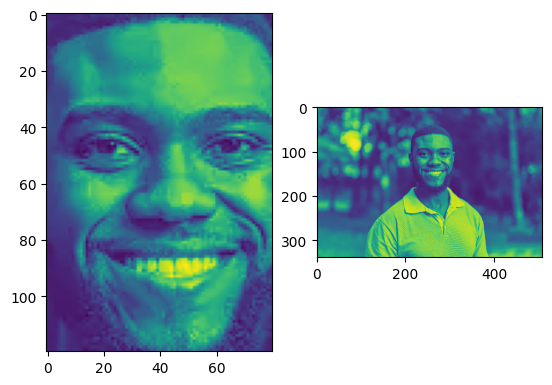

In [2]:
# loading the testing data
img = cv2.imread("test.webp", cv2.IMREAD_GRAYSCALE)
img_3 = cv2.imread("3bros.png", cv2.IMREAD_GRAYSCALE)
face = img[60:180, 220:300]
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(face)
ax1.imshow(img)

# img = img_3

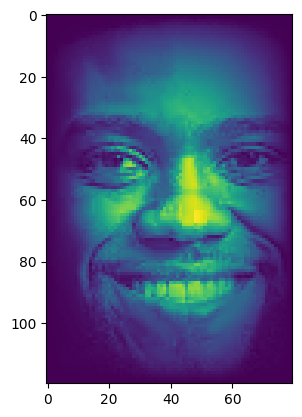

In [3]:
# test to see how our patches look like after smoothing the edges
G = create_cosine_window(face.shape)
cosine_bro = G * face
plt.imshow(cosine_bro)

(101, 201)


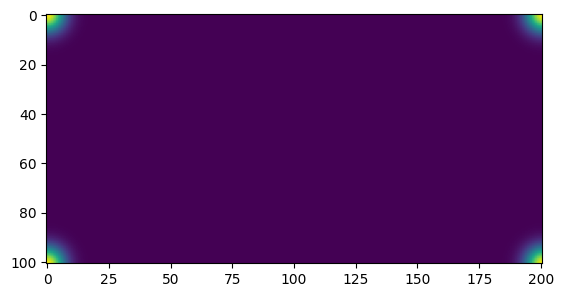

In [4]:
gausian = create_gauss_peak((100,200), 5)
print(gausian.shape)
plt.imshow(gausian)

In [5]:
def to_fourier(img:np.ndarray):
  return np.fft.fft2(img)

def from_fourier(img_h:np.ndarray):
  return np.absolute(np.fft.ifft2(img_h))

def cosinify(img:np.ndarray):
  cosine_w = create_cosine_window(img.shape)
  return cosine_w * img

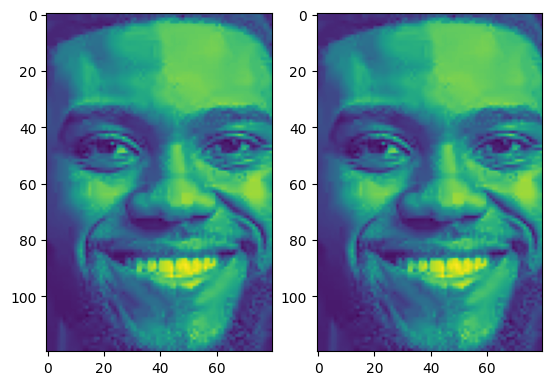

In [6]:
# sanity check
fftd = from_fourier(to_fourier(face))
fig, (ax0, ax1) = plt.subplots(1,2)
ax1.imshow(face)
ax0.imshow(fftd)

In [7]:
def get_filter_response(hhc:np.ndarray, image_h:np.ndarray):
  R = from_fourier(hhc * image_h)
  return R


In [8]:
def get_response_xy(resp):
  y, x = np.unravel_index(resp.argmax(), resp.shape)

  if x > (img.shape[1]/2):
    x = x - img.shape[1]/2

  if y > (img.shape[0]/2):
    y = y - img.shape[0]/2
  

  return x,y

image_h = to_fourier(cosinify(img))
print(face.shape, img.shape)

(120, 80) (339, 509)


/tmp/ipykernel_13872/410416208.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


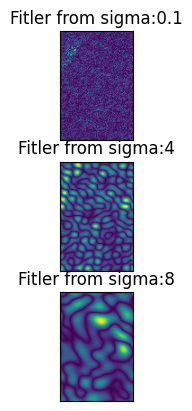

In [9]:
fig, axes= plt.subplots(3,1)

for ax, sigma in zip(axes, [0.1,  4, 8]):
  G = create_gauss_peak(face.shape, sigma)
  size = (G.shape[1], G.shape[0])
  patch, _ = get_patch(img, (100,230), size)
  patch = cosinify(patch)
  G_hat = to_fourier(G)
  patch_hat = to_fourier(patch)
  # filter
  top = G_hat * np.conj(patch_hat)
  bot = patch_hat * np.conj(patch_hat) + 0.1
  H = ( top / bot)
  im = from_fourier(H)

  ax.imshow(im)
  ax.set
  ax.set_title(f"Fitler from sigma:{sigma}")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

fig.show()

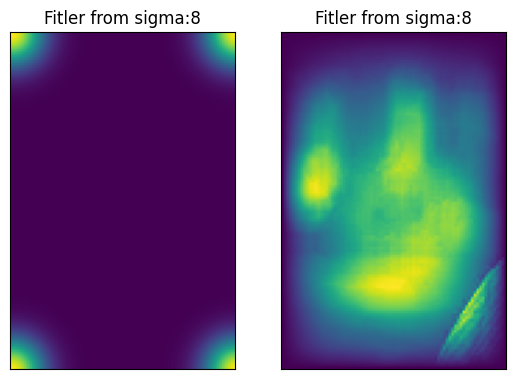

In [10]:
fig, (ax0, ax1)= plt.subplots(1,2)
G = create_gauss_peak(face.shape, sigma)
size = (G.shape[1], G.shape[0])
patch, _ = get_patch(img, (100,230), size)
patch = cosinify(patch)
G_hat = to_fourier(G)
patch_hat = to_fourier(patch)
# filter
top = G_hat * np.conj(patch_hat)
bot = patch_hat * np.conj(patch_hat) + 0.1
H = ( top / bot)
im = from_fourier(H)

ax0.imshow(from_fourier(G_hat))
ax0.set
ax0.set_title(f"Fitler from sigma:{sigma}")
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(patch)
ax1.set
ax1.set_title(f"Fitler from sigma:{sigma}")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# TRACKING


Preparing tracking environment for **VOT**

In [11]:
import time
import cv2
from sequence_utils import VOTSequence


def track(tracker, sequence="car"):
  # set the path to directory where you have the sequences
  dataset_path = "data"

  # visualization and setup parameters
  win_name = "Tracking window"
  reinitialize = True
  show_gt = False
  video_delay = 15
  font = cv2.FONT_HERSHEY_PLAIN

  # create sequence object
  sequence = VOTSequence(dataset_path, sequence)
  init_frame = 0
  n_failures = 0

  time_all = 0

  # initialize visualization window
  sequence.initialize_window(win_name)
  # tracking loop - goes over all frames in the video sequence
  frame_idx = 0
  while frame_idx < sequence.length():
    img = cv2.imread(sequence.frame(frame_idx))
    # initialize or track
    if frame_idx == init_frame:
        # initialize tracker (at the beginning of the sequence or after tracking failure)
        t_ = time.time()
        tracker.initialize(img, sequence.get_annotation(frame_idx, type="rectangle"))
        time_all += time.time() - t_
        predicted_bbox = sequence.get_annotation(frame_idx, type="rectangle")
    else:
        # track on current frame - predict bounding box
        t_ = time.time()
        predicted_bbox = tracker.track(img)
        time_all += time.time() - t_

    # calculate overlap (needed to determine failure of a tracker)
    gt_bb = sequence.get_annotation(frame_idx, type="rectangle")
    o = sequence.overlap(predicted_bbox, gt_bb)

    # draw ground-truth and predicted bounding boxes, frame numbers and show image
    if show_gt:
        sequence.draw_region(img, gt_bb, (0, 255, 0), 1)
    sequence.draw_region(img, predicted_bbox, (0, 0, 255), 2)
    sequence.draw_text(img, "%d/%d" % (frame_idx + 1, sequence.length()), (25, 25))
    sequence.draw_text(img, "Fails: %d" % n_failures, (25, 55))
    sequence.show_image(img, video_delay)

    if o > 0 or not reinitialize:
        # increase frame counter by 1
        frame_idx += 1
    else:
        # increase frame counter by 5 and set re-initialization to the next frame
        frame_idx += 5
        init_frame = frame_idx
        n_failures += 1

  print("Tracking speed: %.1f FPS" % (sequence.length() / time_all))
  print("Tracker failed %d times" % n_failures)
  return n_failures, (sequence.length() / time_all)

## Tracker

In [12]:
# base class for tracker
from typing import Tuple
from IPython.display import clear_output



class Tracker:
    def __init__(self, params):
        self.parameters = params

    def initialize(self, image, region):
        raise NotImplementedError

    def track(self, image):
        raise NotImplementedError

ENLARGE = 2.5
FORGETTING_ALPHA = 0.07
SIGMA = 1.2
LAMBDA = 1e-5

class CorelationTracker(Tracker):
    def __init__(self):
        self.frames = 0

        return

    def initialize(self, image, region):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Region (Left, Top, Width, Height)

        if len(region) == 8:
            x_ = np.array(region[::2])
            y_ = np.array(region[1::2])
            region = [np.min(x_), np.min(y_), np.max(x_) - np.min(x_) + 1,
                      np.max(y_) - np.min(y_) + 1]


        self.size = (region[2]*ENLARGE, region[3]*ENLARGE)
        self.position = (region[0] + region[2] / 2,
                         region[1] + region[3] / 2,)

        self.G = create_gauss_peak(self.size, SIGMA)
        self.size = (self.G.shape[1], self.G.shape[0])
        patch, _ = get_patch(image, self.position, self.size)
        patch = cosinify(patch)
        self.G_hat = to_fourier(self.G)
        patch_hat = to_fourier(patch)

        # filter
        self.top = self.G_hat * np.conj(patch_hat)
        self.bot = patch_hat * np.conj(patch_hat) + LAMBDA
        self.H = ( self.top / self.bot)

    def track(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        patch, _ = get_patch(image, self.position, self.size)
        patch = cosinify(patch)
        patch_hat = to_fourier(patch)

        out = from_fourier(self.H * patch_hat)
        y,x = np.unravel_index(out.argmax(), out.shape)
        y = y - self.size[1] if y > self.size[1] /2 else y
        x = x - self.size[0] if x > self.size[0] /2 else x

        self.position = (self.position[0] + x, self.position[1] + y)

        current_patch, _ = get_patch(image, self.position, self.size)
        current_patch =cosinify( current_patch ) 
        current_patch_hat = to_fourier(current_patch)

        

        top_new = self.G_hat * np.conj(current_patch_hat)
        bot_new = current_patch_hat * np.conj(current_patch_hat) + LAMBDA
        new_H = top_new / bot_new
        
        # self.top = ((1 - FORGETTING_ALPHA) * self.top
        #           + FORGETTING_ALPHA * top_new)
        
        # self.bot = ((1 - FORGETTING_ALPHA) * self.bot
        #           + FORGETTING_ALPHA * bot_new)

        self.H = ((1 - FORGETTING_ALPHA) * self.H
                   + FORGETTING_ALPHA * new_H)


        return [self.position[0] - self.size[0]/(2*ENLARGE),
                self.position[1] - self.size[1]/(2*ENLARGE),
                self.size[1]/ENLARGE, self.size[0]/ENLARGE]


In [13]:
defSig = SIGMA
for i in [-0.2, 0, 0.2]:
  SIGMA  = defSig + i
  track(CorelationTracker(), "hand2")

KeyboardInterrupt: 

In [ ]:
import glob

names =[data.split("/")[-1] for data in glob.glob("./data/*")]
names

for name in names:
  print(name)
  track(CorelationTracker(), name)
  print()

bicycle
Tracking speed: 324.4 FPS
Tracker failed 0 times

bolt
Tracking speed: 97.8 FPS
Tracker failed 3 times

car
Tracking speed: 203.5 FPS
Tracker failed 0 times

drunk
Tracking speed: 92.3 FPS
Tracker failed 0 times

hand2
Tracking speed: 165.7 FPS
Tracker failed 15 times



In [14]:
# alpha grisearch
x=[]
y1 = []
y2 = []

ENLARGE = 2.5
for i in np.linspace(0,1, 15):
  failures, fps = track(CorelationTracker(), "hand2")
  x.append(i)
  y1.append(failures)
  y2.append(fps)

Tracking speed: 101.9 FPS
Tracker failed 16 times
Tracking speed: 118.8 FPS
Tracker failed 16 times
Tracking speed: 135.6 FPS
Tracker failed 16 times
Tracking speed: 124.9 FPS
Tracker failed 16 times
Tracking speed: 134.0 FPS
Tracker failed 16 times
Tracking speed: 120.9 FPS
Tracker failed 16 times
Tracking speed: 122.0 FPS
Tracker failed 16 times
Tracking speed: 126.6 FPS
Tracker failed 16 times
Tracking speed: 142.5 FPS
Tracker failed 16 times
Tracking speed: 147.9 FPS
Tracker failed 16 times
Tracking speed: 152.9 FPS
Tracker failed 16 times
Tracking speed: 132.0 FPS
Tracker failed 16 times
Tracking speed: 126.0 FPS
Tracker failed 16 times
Tracking speed: 124.5 FPS
Tracker failed 16 times
Tracking speed: 106.1 FPS
Tracker failed 16 times


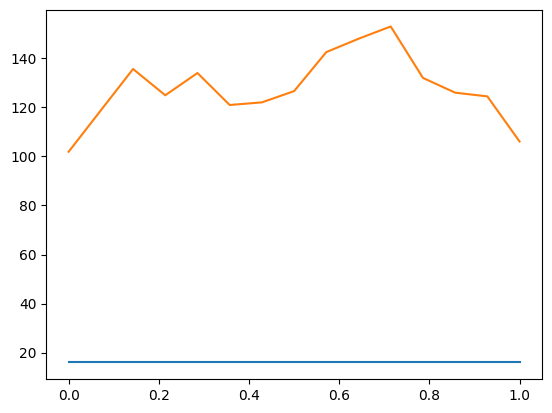

In [17]:
plt.plot(x,y1)
plt.plot(x,y2)